# Data Coverage
Summary:

* One unexpected complexity I discovered was that the temporal resolution of station measurements can change in strange ways.This matters because we need to know the measurement resolution in order to exclude data with poor intra-day coverage. If a mean temperature was based on only daylight hours, for example, it would have a large upward bias compared to a full day average. I expected that over decades, some stations would switch from low resolution 6- or 3-hourly measurements up to 1-hourly resolution, but it turns out they can switch back and forth. I think we'll have to use some changepoint detection methods to pick out those transitions.
* Related to the above, some stations appear to rely on manual data reporting, and only log data during business hours! It is theoretically possible to use this data for analyzing trends as long as that bias is consistent over time. But for now I plan to omit those stations unless we really have no other choice. We'll know whether that is necessary by the end of this week, when I finish the availability analysis.

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import pandas as pd
from pathlib import Path
import numpy as np
import altair as alt

import src.data.reshape as rs

In [4]:
# supplement default JS plots with backup static PNGs.
# This lets them render on GitHub
alt.renderers.enable('mimetype')

RendererRegistry.enable('mimetype')

In [5]:
pd.options.display.max_columns= 50

In [6]:
gsod = rs.get_gsod()

In [7]:
station_meta = rs.get_station_metadata()

In [8]:
station_meta = station_meta.loc[station_meta['distance_km'] <= 50]
station_meta.shape

(344, 13)

In [9]:
station_meta = station_meta.set_index(['usaf', 'wban'])

In [10]:
#gsod = gsod.merge(stations[['usaf', 'wban', 'nearest_city']], on=['usaf', 'wban'])
gsod.head(3)

,timestamp,usaf,wban,temp_f_mean,temp_count,dew_point_f_mean,dew_point_count,sea_level_pressure_mbar_mean,sea_level_pressure_count,pressure_mbar_mean,pressure_count,visbility_miles_mean,visbility_count,wind_speed_knots_mean,wind_speed_count,temp_f_max,temp_max_measurement_type,temp_f_min,temp_min_measurement_type,precipitation_total_inches,precipitation_measurement_type,snow_depth_inches,had_rain,had_snow_ice,had_hail
0,1985-01-26,691484,99999,38.099998,5,37.400002,5,NaN,0,NaN,0,4.8,5,5.2,5,39.200001,*,37.400002,*,NaN,NaN,0.8,1,0,0
1,1985-01-27,691484,99999,34.500000,5,30.600000,5,NaN,0,NaN,0,4.9,5,3.8,5,39.200001,*,30.200001,*,NaN,NaN,NaN,1,1,0
2,1985-01-28,691484,99999,26.900000,17,20.100000,17,NaN,0,NaN,0,5.9,17,2.5,17,33.799999,*,19.400000,*,0.0,I,NaN,0,0,0


In [11]:
station_ids = gsod[['usaf', 'wban']].drop_duplicates()
station_ids.shape

(223, 2)

In [12]:
gsod = gsod.set_index(['usaf', 'wban']).sort_index()

In [13]:
random_station_id = tuple(station_ids.sample(1, random_state=1).to_numpy()[0])
# see below station for example of operating style with ~15 hourly observations per day.
# They don't report data between 9pm and 8am!
# This produces a massive diurnal bias to mean temperatures.
# But if we care ONLY about trends, it is OK as long as it stays consistent.
# I assume this reporting pattern is responsible for all stations with
# temp_count values clustered around 15.
#random_station_id = ('724937', '23289')

In [14]:
station_meta.loc[random_station_id,:]

name                         ALAMEDA(USN)
country                                US
state                                  CA
call                                 KNGZ
latitude                           37.733
longitude                        -122.317
elevation_ft                          4.0
nominal_begin_date    1973-01-01 00:00:00
nominal_end_date      1997-01-02 00:00:00
nearest_city                San Francisco
distance_km                     10.139449
Name: (745060, 23239), dtype: object

In [15]:
random_station = gsod.loc[random_station_id,:].set_index('timestamp').sort_index()
#random_station.head()

<AxesSubplot:xlabel='timestamp'>

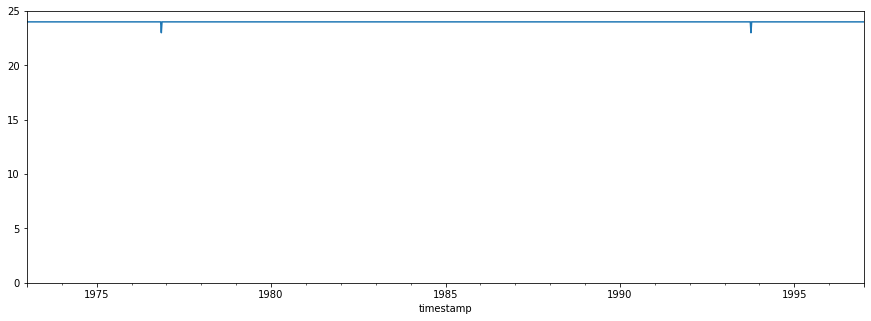

In [16]:
random_station.resample('7d')['temp_count'].max().plot(figsize=(15,5), ylim=(0,25))

Discovered a fair amount of complexity in the `temp_count` timeseries:
* changes over time (as expected)
* not always stable - can go from 8 to 24 to 4 and back to 8. (not expected)
* some stations have random distributions of max counts \[This is because some stations seem to be manually reported: no data overnight.\]
To do:
- [ ] make func to plot data coverage of a station
- [ ] plot each city's stations
- [ ] make func to summarize outage periods

<AxesSubplot:xlabel='timestamp'>

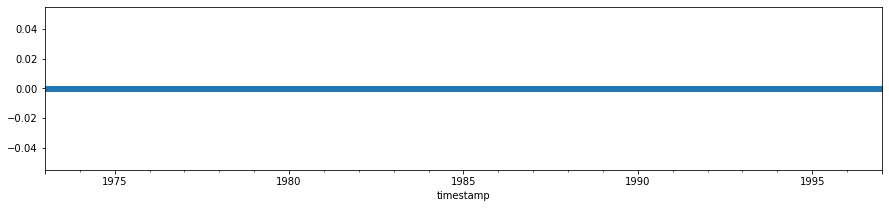

In [17]:
random_station['temp_f_mean'].asfreq('D').isna().astype(np.uint8).plot(linestyle='none', marker='|', figsize=(15,3), markersize=5)

In [18]:
data_periods = gsod.groupby(['usaf', 'wban'])['timestamp'].agg(['min', 'max', 'count'])

In [19]:
station_meta['nominal_duration_years'] = station_meta.loc[:, 'nominal_end_date'].sub(station_meta.loc[:, 'nominal_begin_date']).dt.days / 365.25
station_meta.head(3)

,,name,country,state,call,latitude,longitude,elevation_ft,nominal_begin_date,nominal_end_date,nearest_city,distance_km,nominal_duration_years
usaf,wban,,,,,,,,,,,,
690320,99999,BLAINE HARBOR MUNI,US,WA,WA09,48.983,-122.733,21.0,1992-04-16,1994-03-03,Vancouver,43.664391,1.878166
691484,99999,FAIRCHILD AFB / EXERCISE,US,WA,NaN,47.617,-117.667,750.4,1984-07-09,1995-05-02,Spokane,18.641562,10.811773
720046,99999,NEWHALL,US,CA,K3A6,34.370,-118.570,427.0,2004-02-24,2011-09-05,Los Angeles,46.355812,7.529090


In [20]:
# Aggressive Subset
threshold_years = 3
threshold_date = '1900-01-01'
station_meta.query("(nominal_duration_years > @threshold_years or nominal_begin_date < @threshold_date)").shape

(297, 12)

In [21]:
shortlist_meta = data_periods.query("count > (@threshold_years*0.8*365.25) or min < @threshold_date")
shortlist_meta.shape

(210, 3)

In [48]:
shortlist_meta['time_coverage'] = shortlist_meta['count'] / (shortlist_meta['max'].sub(shortlist_meta['min']).dt.days + 1)

In [23]:
shortlist_meta = shortlist_meta.join(station_meta, how='left')

In [24]:
subset = gsod.loc[shortlist_meta.index, ['timestamp', 'temp_f_mean', 'temp_count']].set_index('timestamp', append=True)

In [25]:
subset.shape

(1848439, 2)

In [26]:
# are all cities covered?
assert shortlist_meta['nearest_city'].nunique() == 20

In [27]:
resolution_months = 12
subset_resampled = subset.reset_index(level=['usaf', 'wban']).groupby(['usaf', 'wban']).resample(f'{resolution_months}MS')['temp_f_mean'].count()
subset_resampled.rename('count_days', inplace=True)

usaf    wban   timestamp 
710370  99999  2003-06-01    338
               2004-06-01    345
               2005-06-01    361
               2006-06-01    365
               2007-06-01    357
                            ... 
999999  94074  2017-07-01    279
               2018-07-01    365
               2019-07-01    366
               2020-07-01    365
               2021-07-01    291
Name: count_days, Length: 6197, dtype: int64

In [28]:
subset_resampled = subset_resampled.replace(0, np.nan).dropna()

In [29]:
subset_resampled.shape

(5442,)

In [30]:
subset_resampled = subset_resampled.to_frame().join(shortlist_meta[['name', 'nearest_city']])
subset_resampled.head(2)

count_days            name nearest_city
usaf   wban  timestamp                                          
710370 99999 2003-06-01       338.0  POINT ATKINSON    Vancouver
             2004-06-01       345.0  POINT ATKINSON    Vancouver

In [31]:
subset_resampled['end_period'] = subset_resampled.index.get_level_values('timestamp') + pd.DateOffset(months=resolution_months)

In [32]:
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

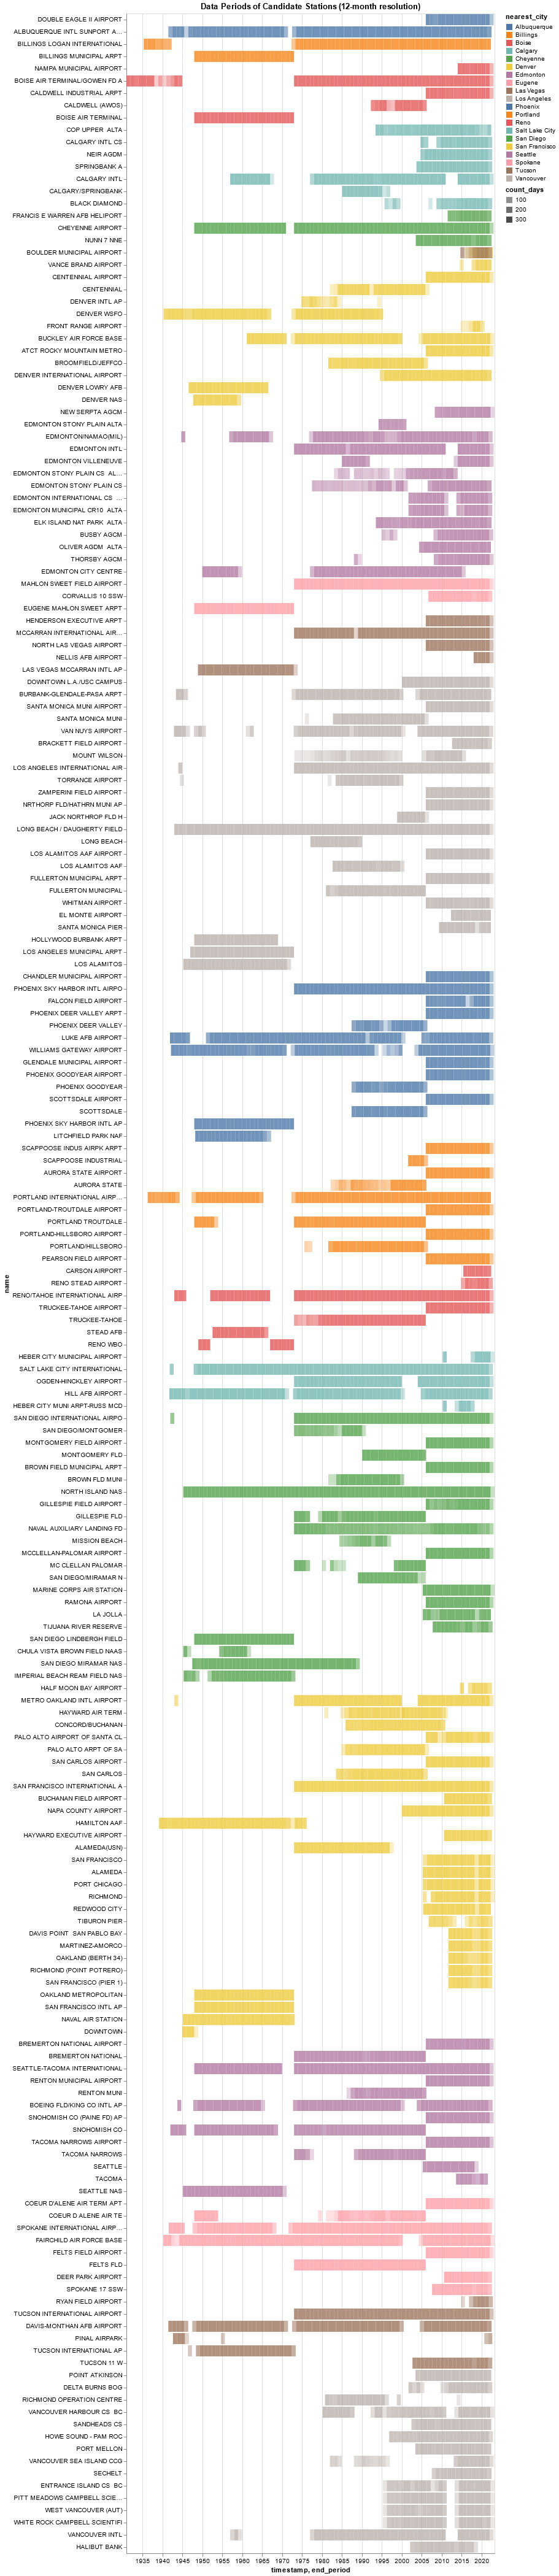

In [33]:
alt.Chart(subset_resampled.reset_index()).mark_bar().encode(
    alt.X('timestamp:T'),
    alt.X2('end_period:T'),
    alt.Y('name:N', sort='color'),
    color='nearest_city:N',
    opacity='count_days:Q',
).properties(
    title=f"Data Periods of Candidate Stations ({resolution_months}-month resolution)"
).configure_view(
    #continuousHeight=200,
    continuousWidth=600,
)

Text(0, 0.5, 'Years')

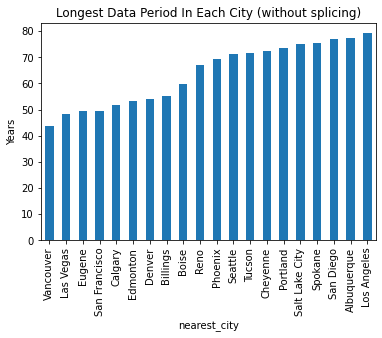

In [34]:
ax = shortlist_meta.groupby('nearest_city')['count'].max().div(365.25).sort_values().plot.bar(title="Longest Data Period In Each City (without splicing)")
ax.set_ylabel("Years")

## Stations to Use

In [71]:
stations = [
    # ALBUQUERQUE
    "ALBUQUERQUE INTL SUNPORT",
    # Billings
    "BILLINGS LOGAN INTERNATIONAL",
    "BILLINGS MUNICIPAL ARPT",
    # BOISE
    "BOISE AIR TERMINAL/GOWEN",
    "BOISE AIR TERMINAL",
    # CALGARY
    "CALGARY INTL",
    # CHEYENNE
    "CHEYENNE AIRPORT",
    # DENVER
    "BUCKLEY AIR FORCE BASE",
    # EDMONTON
    "EDMONTON/NAMAO",
    "EDMONTON INTL",
    # EUGENE
    "MAHLON SWEET FIELD AIRPORT",
    "EUGENE MAHLON SWEET ARPT",
    # LAS VEGAS
    "MCCARRAN INTERNATIONAL",
    "LAS VEGAS MCCARRAN INTL AP",
    # LOS ANGELES
    "LONG BEACH / DAUGHERTY FIELD",
    "LOS ANGELES INTERNATIONAL AIR",
    "LOS ANGELES MUNICIPAL ARPT",
    "BURBANK-GLENDALE-PASA ARPT",
    "HOLLYWOOD BURBANK ARPT",
    # PHOENIX
    "LUKE AFB AIRPORT",
    "WILLIAMS GATEWAY AIRPORT",
    "PHOENIX SKY HARBOR INTL AP",
    "PHOENIX SKY HARBOR INTL AIR",
    # PORTLAND
    "PORTLAND INTERNATIONAL AIR",
    "PORTLAND TROUTDALE",
    "PORTLAND-TROUTDALE AIRPORT",
    # RENO
    "RENO/TAHOE INTERNATIONAL AIR",
    "TRUCKEE-TAHOE AIRPORT",
    "TRUCKEE-TAHOE",
    # SALT LAKE CITY
    "SALT LAKE CITY INTERNATIONAL",
    "HILL AFB AIRPORT",
    # SAN DIEGO
    "NORTH ISLAND NAS",
    "SAN DIEGO LINDBERGH FIELD",
    "SAN DIEGO INTERNATIONAL AIR",
    "SAN DIEGO MIRAMAR NAS",
    "SAN DIEGO/MIRAMAR",
    "MARINE CORPS AIR STATION",
    # SAN FRANCISCO
    "OAKLAND METROPOLITAN",
    "METRO OAKLAND INTL AIRPORT",
    "SAN FRANCISCO INTL AP",
    "SAN FRANCISCO INTERNATIONAL",
    "NAVAL AIR STATION",
    "ALAMEDA(USN)",
    "ALAMEDA",
    # SEATTLE
    "SEATTLE-TACOMA INTERNATIONAL",
    "BOEING FLD/KING CO",
    "SNOHOMISH CO",
    "SNOHOMISH (PAINE FD) AP",
    # SPOKANE
    "SPOKANE INTERNATIONAL AIRPORT",
    "FAIRCHILD AIR FORCE BASE",
    # TUCSON
    "TUCSON INTERNATIONAL AIRPORT",
    "TUCSON INTERNATIONAL AP",
    "DAVIS-MONTHAN AFB AIRPORT",
    # VANCOUVER
    "VANCOUVER INTL",
]

In [72]:
used_meta = pd.concat([shortlist_meta.loc[shortlist_meta.loc[:, 'name'].str.strip().str.startswith(station)] for station in stations]).drop_duplicates()

In [73]:
# drop false positive station
used_meta = used_meta.loc[~used_meta.loc[:, 'name'].eq('CALGARY INTL CS')]

In [77]:
assert len(used_meta) == len(stations)

In [74]:
used_meta.shape

(54, 16)

In [75]:
used_meta

,,min,max,count,time_coverage,name,country,state,call,latitude,longitude,elevation_ft,nominal_begin_date,nominal_end_date,nearest_city,distance_km,nominal_duration_years
usaf,wban,,,,,,,,,,,,,,,,
723650,23050,1941-07-01,2022-04-17,28281,0.958321,ALBUQUERQUE INTL SUNPORT AIRP,US,NM,KABQ,35.042,-106.616,1618.5,1941-07-01,2021-09-21,Albuquerque,5.659381,80.224504
726770,24033,1935-05-01,2022-04-17,20143,0.634146,BILLINGS LOGAN INTERNATIONAL,US,MT,KBIL,45.807,-108.542,1091.5,1935-05-01,2021-09-21,Billings,4.148528,86.392882
999999,24033,1948-01-01,1972-12-31,9132,1.000000,BILLINGS MUNICIPAL ARPT,US,MT,KBIL,45.807,-108.542,1088.1,1948-01-01,1972-12-31,Billings,4.148528,24.999316
726810,24131,1931-01-01,2022-04-17,21763,0.652662,BOISE AIR TERMINAL/GOWEN FD A,US,ID,KBOI,43.567,-116.241,875.4,1931-01-01,2021-09-21,Boise,6.181994,90.721424
999999,24131,1948-01-01,1972-12-31,9130,0.999781,BOISE AIR TERMINAL,US,ID,KBOI,43.567,-116.241,874.2,1948-01-01,1972-12-31,Boise,6.181994,24.999316
718770,99999,1957-01-01,2022-04-16,18828,0.789533,CALGARY INTL,CA,NaN,CYYC,51.114,-114.020,1084.2,1955-07-02,2021-09-20,Calgary,8.512304,66.220397
725640,24018,1948-01-01,2022-04-17,26405,0.973062,CHEYENNE AIRPORT,US,WY,KCYS,41.158,-104.807,1863.2,1948-01-01,2021-09-21,Cheyenne,2.290103,73.722108
724695,23036,1961-03-01,2022-04-17,19761,0.885032,BUCKLEY AIR FORCE BASE,US,CO,KBKF,39.717,-104.750,1726.1,1944-03-01,2021-09-21,Denver,20.694128,77.557837
711210,99999,1944-10-10,2022-04-14,19426,0.686164,EDMONTON/NAMAO(MIL),CA,NaN,CYED,53.667,-113.467,688.0,1944-10-10,2021-09-20,Edmonton,13.556684,76.944559


### Splice Candidates
All the candidates share lat/lon **except** "ALAMEDA", which is about 2km away from the former Naval Air Station in Alameda. 

In [35]:
raise ValueError

ValueError: 

In [76]:
used_meta.reset_index().to_csv('../data/interim/stations_for_scoping_analysis.csv', index=False)

In [ ]:
subset = subset.unstack(['wban', 'usaf']).asfreq('1d').stack(['wban', 'usaf'], dropna=False)
subset.index = subset.index.reorder_levels(order=['usaf', 'wban', 'timestamp'])
subset.sort_index(inplace=True)
subset.head()

In [ ]:
shortlist_meta.loc[shortlist_meta['name'].str.startswith('CHEYENNE')]

In [ ]:
# Long Beach
gsod.loc[('722970', '23129'), ['timestamp', 'temp_f_mean']].set_index('timestamp').resample('AS').mean().iloc[:-1].plot(figsize=(15,4), grid=True)

In [ ]:
# North Island
gsod.loc[('722906', '93112'), ['timestamp', 'temp_f_mean']].set_index('timestamp').resample('AS').mean().iloc[:-1].plot(figsize=(15,4), grid=True)

In [ ]:
# Cheyenne Airport
gsod.loc[('725640', '24018'), ['timestamp', 'temp_f_mean']].set_index('timestamp').resample('AS').mean().iloc[:-1].plot(figsize=(15,4), grid=True)

In [ ]:
test = data_periods.join(station_meta, how='left')

In [ ]:
test.loc[test['name'].str.startswith('DENVER')]